In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

import sys
sys.path.append('../')
from utils import *

In [2]:
df = pd.read_pickle('../../data/datasets/video-level-watches+autoencoded-upnext')
videos = pd.read_pickle('../../data/videos_raw_metadata')
title_embeddings = pd.read_pickle('../../data/embeddings/title-autoencoded')

2023-07-15 21:48:16.008017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-15 21:48:16.008072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-15 21:48:18.406482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-15 21:48:18.406540: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-15 21:48:18.406580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (toutatis): /proc/driver/nvidia/version does not exist
2023-07-15 21:48:18.406984: I tensorflow/core/platform/cpu_feature_g

In [3]:
X = []
Y = []
for watch in tqdm(df):
    playing = watch['playing']
    selected = watch['selected']
    if playing not in videos or selected not in videos or any([s not in videos for s in watch['upnext']]):
        continue

    if len(watch['upnext']) < 15:
        continue
        
    upnext = watch['upnext'][:15]
    for s in upnext:
        playing = watch['playing']
        selected = watch['selected']

        if s == selected:
            y = 1
        else:
            y = 0

        playing = np.array(title_embeddings[videos[playing]['snippet']['title']])[0]
        suggested = np.array(title_embeddings[videos[s]['snippet']['title']])[0]
        
        all_suggested = np.array(watch['upnext_embs'])[0]

        x = np.concatenate([playing, suggested, all_suggested])

        X.append(x)
        Y.append(y)

  0%|          | 0/6050 [00:00<?, ?it/s]

In [4]:
X = np.array(X)
Y = np.array(Y)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [6]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
X_train.shape

(55188, 384)

In [8]:
pos = Y.sum()
neg = len(Y) - pos
total = neg + pos
w0 = (1 / neg) * (total / 2.0)
w1 = (1 / pos) * (total / 2.0)
class_weights = {0:w0, 1:w1}
class_weights

{0: 0.534742570113018, 1: 7.69578313253012}

In [9]:
# train neural network

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD


model = Sequential()
model.add(Dense(384, activation='relu', input_dim=384))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)

METRICS = [keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'), 
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),       
            keras.metrics.AUC(name='prc', curve='PR')]
# import sgd

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=METRICS)

model.fit(X_train, y_train,
            epochs=100,
            batch_size=16, 
            class_weight=class_weights)

/home/data/hussam/miniconda3/envs/jup/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
3450/3450 [==============================] - 33s 8ms/step - loss: 0.6942 - tp: 2140.0000 - fp: 30842.0000 - tn: 20760.0000 - fn: 1446.0000 - accuracy: 0.4149 - precision: 0.0649 - recall: 0.5968 - auc: 0.4986 - prc: 0.0643
Epoch 2/100
3450/3450 [==============================] - 28s 8ms/step - loss: 0.6935 - tp: 2216.0000 - fp: 32025.0000 - tn: 19577.0000 - fn: 1370.0000 - accuracy: 0.3949 - precision: 0.0647 - recall: 0.6180 - auc: 0.4957 - prc: 0.0638
Epoch 3/100
3450/3450 [==============================] - 27s 8ms/step - loss: 0.6934 - tp: 1689.0000 - fp: 24606.0000 - tn: 26996.0000 - fn: 1897.0000 - accuracy: 0.5198 - precision: 0.0642 - recall: 0.4710 - auc: 0.5008 - prc: 0.0648
Epoch 4/100
3450/3450 [==============================] - 27s 8ms/step - loss: 0.6934 - tp: 1914.0000 - fp: 26734.0000 - tn: 24868.0000 - fn: 1672.0000 - accuracy: 0.4853 - precision: 0.0668 - recall: 0.5337 - auc: 0.5033 - prc: 0.0654
Epoch 5/100
3450/3450 [==============================] - 28s

KeyboardInterrupt: 

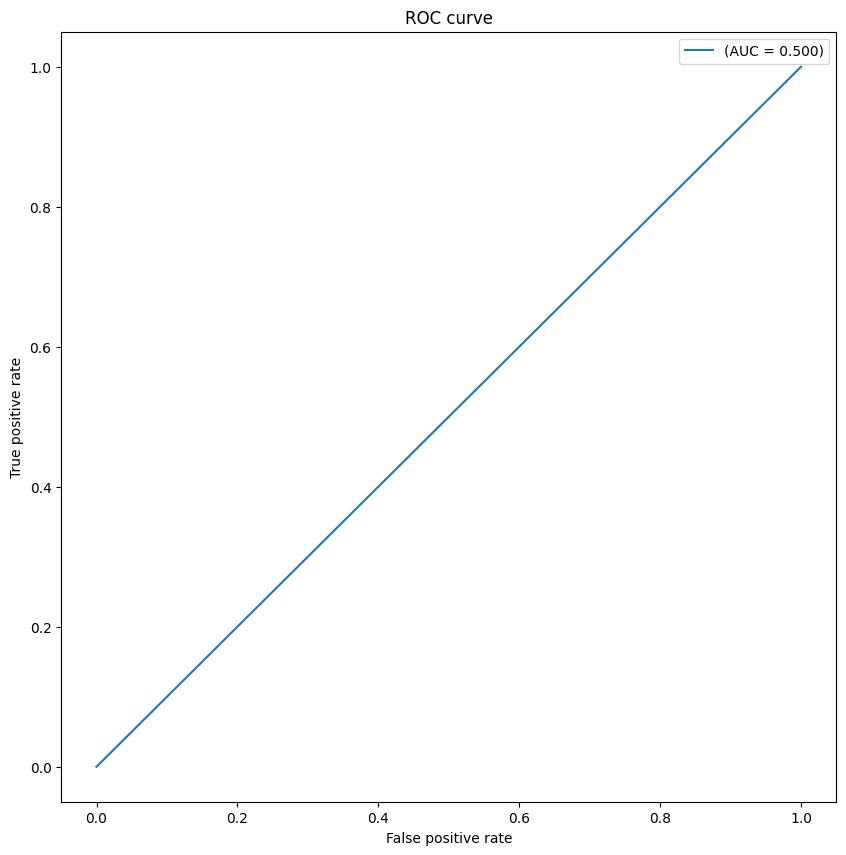

In [10]:
# plot auc curve for test

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,10))
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()